### Guide to this File:

This file is intended to be ran from other notebooks. This file will only return time_series for one hero to reduce workload and help with troubleshooting.

This file will create the following objects:

df : match data [match_id, hero_id, gold_t]
df_no_match : match data without match_id [hero_id, gold_t]

missing_indices : indices that had missing gold_t values and were removed, use with print() to view
df.loc[missing_indices, ['hero_id','gold_t']] : to be used to view missing_indices

zero_length_indices : the indices containing zero length gold_t values and were removed
zero_length_records : the records containing zero length gold_t values and were removed




In [32]:
import json
import pandas as pd 
import requests
from numpy import array
import numpy as np

import torch
import torch.nn
import torch.optim as optim

# Used in LTSMModel Class Instantiation
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Local Load

file_path = "C:\\Users\\dcrai\\source\\repos\\DATA698\\Code\\Data\\data.json"
file_path_hero = "C:\\Users\\dcrai\\source\\repos\\DATA698\\Code\\Data\\hero_id_table.csv"
#file_csv = "C:\\Users\\dcrai\\source\\repos\\DATA698\\Code\\Data\\iter_1.csv" - different match data

with open(file_path, 'r') as file:
    data = json.load(file)

# Github Load

#file_path = "https://raw.githubusercontent.com/d-ev-craig/DATA698/main/Code/Data/data.json"
#file_path_hero = "https://raw.githubusercontent.com/d-ev-craig/DATA698/main/Code/Data/hero_id_table.csv"

#response = requests.get(file_path)
#data = json.loads(response.text)

# Create heroes dataframe
heroes= pd.read_csv(file_path_hero)

# Extract 'match_id', 'hero_id', and 'gold_t' from each element in 'data'
match_ids = [element['match_id'] for element in data]
hero_ids = [element['hero_id'] for element in data]
gold_t_values = [element['gold_t'] for element in data]

# Create match data dataframe
df = pd.DataFrame({'match_id': match_ids, 'hero_id': hero_ids, 'gold_t': gold_t_values})




In [4]:
# Match ID example
#7517376613

# Checking zero length tensors

#df.iloc[2470]
#df.iloc[2511]

### Missing Data Drop

In [5]:
missing_mask = df['gold_t'].isnull()
missing_indices = df.index[missing_mask]
#print(missing_indices)
df.loc[missing_indices, ['hero_id','gold_t']]

df = df.dropna(subset=['gold_t'])
df = df.reset_index(drop=True) # Reset the indexes so no issues arise with using index locations to drop 0 length tensors

### Zero Length Tensors Drop

If we don't drop the zero length tensors, when we call `model(hero_ids,time_series)` in the training loop, it will error out when attempting to run pad_packed_sequence

We are also dropping any games with less than 11 minutes, since the model is trained using a 10 minute lookback window.


### Games <10 minutes

Since the model performs drastically better on games lasting more than 10 minutes, we will remove games less than 11.

In [6]:
zero_length_indices = []

for index, time_series in enumerate(df['gold_t']):
    if len(time_series) < 11:
        zero_length_indices.append(index)


if len(zero_length_indices) > 0:
    print(f"Found {len(zero_length_indices)} tensors with length 0 at indices: {zero_length_indices}")
else:
    print("No tensors with length 0 found.")

Found 34 tensors with length 0 at indices: [810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 2460, 2501, 2512, 2583, 5414, 5415, 5416, 5417, 5418, 5419, 5420, 5421, 5422, 5423]


In [7]:
zero_length_records = df.loc[zero_length_indices, ['hero_id','gold_t']]

#df_full.iloc[2583][['hero_id','gold_t']]
#len(df_full.iloc[2460]['gold_t'])

In [8]:
# Different methods to reduce data size for testing

#df_match = df[df['match_id'] == 7517376613]
#df_match = df[:300]
#df_match

#df_subset = df_match[['hero_id', 'gold_t']].copy()
#df_subset

df = df.drop(zero_length_indices).reset_index(drop = True)
df_no_match = df[['hero_id', 'gold_t']].copy()


In [43]:
def build_hero_ts_df(df, list_length='Longest'):
    df_allhero = pd.DataFrame(columns=['match_id', 'hero_id', 'gold_t'])
    hero_ids = sorted(df['hero_id'].unique().tolist())
    df_remain = df

    for hero_id in hero_ids:
        if list_length == 'Longest':
            idx = df[df['hero_id'] == hero_id]['gold_t'].apply(len).idxmax()
        elif list_length == 'Average':
            idx = (df[df['hero_id'] == hero_id]['gold_t'].apply(len) -
                   df[df['hero_id'] == hero_id]['gold_t'].apply(len).mean().round().astype(int)).abs().idxmin()
        else:
            raise ValueError("Invalid list_length parameter. Choose either 'Longest' or 'Average'.")

        df_remain = df_remain.drop([idx])
        df_onets = df.iloc[idx].to_frame().T
        df_allhero = pd.concat([df_allhero, df_onets], axis=0, ignore_index=True).sort_values(by='hero_id', ascending=True)

    return df_allhero, hero_ids, df_remain

df_allhero, hero_ids, df_all_remain = build_hero_ts_df(df)
df_allhero_avglen, hero_ids_avglen, df_avg_remain = build_hero_ts_df(df, 'Average')

In [30]:
# Old Version - Only good for longest
# def build_hero_longest_ts_df(df): 
#     df_allhero = pd.DataFrame(columns = ['match_id','hero_id','gold_t'])
#     hero_ids = sorted(df['hero_id'].unique().tolist())
#     for hero_id in hero_ids:
#         idx_max = df[df['hero_id']==hero_id]['gold_t'].apply(len).idxmax() #print(idx_max)
#         df_onets = df.iloc[idx_max].to_frame().T
#         #print(df_onets)
#         df_allhero = pd.concat([df_allhero,df_onets], axis = 0, ignore_index= True).sort_values(by = 'hero_id',ascending = True) 
#         #print(df_allhero)
#         #print(len(df_allhero))
#     return df_allhero, hero_ids

#df_allhero_test, hero_ids_test = build_hero_longest_ts_df(df)

In [24]:
# Checking to see if results were equivalent
# mask = (df_allhero == df_allhero_test)
# false_indexes = mask.index[~mask.all(axis=1)].tolist()
# print("Indexes of rows containing False:", false_indexes)

Indexes of rows containing False: []


In [ ]:
# hero_ids == hero_ids_avglen

### Hero_ID Filter

In [19]:
df_no_match['hero_id'].value_counts()

20     307
26     269
86     243
106    235
21     234
      ... 
111     15
77      15
34       6
108      6
99       5
Name: hero_id, Length: 124, dtype: int64

In [9]:
hero_filter_value = df_no_match['hero_id'].value_counts().idxmax()
#.value_counts() - counts the number of instances each value of hero_id, sorts descending by default
# Important to note that .value_counts replaces the index with the value of the hero_id, meaning we need to pull that index value for our hero to filter by
#.idxmax() - selects the index value that contains the highest value

df_hero_filtered = df_no_match[df_no_match['hero_id'] == hero_filter_value].reset_index(drop=True)
df_20 = df_hero_filtered['gold_t']

In [17]:
df_hero_filtered.iloc[0][['gold_t']]
df_20

0      [0, 239, 368, 723, 1136, 1958, 2287, 2538, 324...
1      [0, 170, 310, 522, 626, 768, 907, 1042, 1182, ...
2      [0, 210, 300, 390, 480, 713, 848, 938, 1104, 1...
3      [0, 170, 260, 350, 456, 634, 797, 920, 1169, 1...
4      [0, 303, 835, 1091, 1469, 1810, 2271, 2942, 30...
                             ...                        
302    [0, 170, 260, 395, 525, 662, 867, 1001, 1252, ...
303    [63, 272, 362, 452, 542, 891, 981, 1140, 1275,...
304    [0, 170, 260, 518, 608, 709, 799, 993, 1228, 1...
305    [0, 210, 351, 518, 668, 876, 1106, 1350, 1484,...
306    [0, 169, 259, 349, 563, 698, 834, 1059, 1305, ...
Name: gold_t, Length: 307, dtype: object

In [11]:
type(df_20[0])

# Assuming your dataframe is called df_20

# Convert each row from a list to a pandas Series
df_20_series = df_20.apply(lambda x: pd.Series(x))
df_20_series

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,0.0,239.0,368.0,723.0,1136.0,1958.0,2287.0,2538.0,3248.0,3515.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,170.0,310.0,522.0,626.0,768.0,907.0,1042.0,1182.0,1272.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,210.0,300.0,390.0,480.0,713.0,848.0,938.0,1104.0,1259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,170.0,260.0,350.0,456.0,634.0,797.0,920.0,1169.0,1779.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,303.0,835.0,1091.0,1469.0,1810.0,2271.0,2942.0,3070.0,3613.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.0,170.0,260.0,395.0,525.0,662.0,867.0,1001.0,1252.0,1342.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,63.0,272.0,362.0,452.0,542.0,891.0,981.0,1140.0,1275.0,1492.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,0.0,170.0,260.0,518.0,608.0,709.0,799.0,993.0,1228.0,1414.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,0.0,210.0,351.0,518.0,668.0,876.0,1106.0,1350.0,1484.0,1728.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_20_series.iloc[:, 9:13]


,9,10,11,12
0,3515.0,3823.0,4397.0,4870.0
1,1272.0,1644.0,1793.0,2007.0
2,1259.0,1597.0,1687.0,1982.0
3,1779.0,1914.0,2182.0,2272.0
4,3613.0,4476.0,4734.0,5212.0
...,...,...,...,...
302,1342.0,1613.0,1872.0,2038.0
303,1492.0,1771.0,2074.0,2182.0
304,1414.0,1525.0,1654.0,2064.0
305,1728.0,1998.0,2089.0,2384.0


Below determines the maximum gold seen in all the games to be used as a a value to scale on. We do this so that the data is relatively scaled to an expected new game. The current scaling uses the complete time-series from the match to scale, but the issue in alive scenario is that we won't have the entire timeseries dataset in a live match, so instead we scale it in accordance to the largest value we've seen across matches.

In [33]:
all_heroes_ts = df_no_match['gold_t'].apply(lambda x: pd.Series(x))

max_gold = all_heroes_ts.max().max()
min_gold = 0

def ConstantMinMaxScaler(series,min_gold,max_gold):
    print(type(series))
    #series = np.ndarray(series)
    dataset_scaled = (series - min_gold)/(max_gold - min_gold)
    return dataset_scaled

def ConstantUnScaler(series, min_gold, max_gold):
    #series = np.ndarray(series)
    dataset_unscaled = np.round((series * (max_gold - min_gold)) + min_gold)
    return dataset_unscaled

Scaling Data

In [43]:
scaled_df20 = (df_20_series - min_gold)/(max_gold - min_gold)

scaled_df20

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,0.000000,0.002293,0.003531,0.006938,0.010901,0.018789,0.021946,0.024355,0.031168,0.033730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.001631,0.002975,0.005009,0.006007,0.007370,0.008704,0.009999,0.011343,0.012206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.002015,0.002879,0.003742,0.004606,0.006842,0.008137,0.009001,0.010594,0.012081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.001631,0.002495,0.003359,0.004376,0.006084,0.007648,0.008828,0.011218,0.017071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.002908,0.008013,0.010469,0.014097,0.017369,0.021793,0.028232,0.029460,0.034671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,0.000000,0.001631,0.002495,0.003790,0.005038,0.006353,0.008320,0.009606,0.012014,0.012878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,0.000605,0.002610,0.003474,0.004337,0.005201,0.008550,0.009414,0.010940,0.012235,0.014317,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,0.000000,0.001631,0.002495,0.004971,0.005834,0.006804,0.007667,0.009529,0.011784,0.013569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,0.000000,0.002015,0.003368,0.004971,0.006410,0.008406,0.010613,0.012955,0.014241,0.016582,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
n_steps = 9
predict_steps = 2
# Due to 0 indexing, :n_steps would pull the first 10 steps.. which would be indexes from 0 to 9
# calling n_steps, without the colon like in line 8 where we create y, would pull the index at 10
# This allows us to only declare n_steps

def split_sequence(sequence, n_steps, predict_steps):

    X = sequence.iloc[:, :n_steps]
    y = sequence.iloc[:, n_steps:n_steps+predict_steps]

    return X,y

X,y = split_sequence(df_20_series,n_steps, predict_steps)
X_scaled,y_scaled = split_sequence(scaled_df20, n_steps, predict_steps)

#print(X)
#print(y)

In [40]:
X_scaled

,0,1,2,3,4,5,6,7,8
0,0.000000,0.002293,0.003531,0.006938,0.010901,0.018789,0.021946,0.024355,0.031168
1,0.000000,0.001631,0.002975,0.005009,0.006007,0.007370,0.008704,0.009999,0.011343
2,0.000000,0.002015,0.002879,0.003742,0.004606,0.006842,0.008137,0.009001,0.010594
3,0.000000,0.001631,0.002495,0.003359,0.004376,0.006084,0.007648,0.008828,0.011218
4,0.000000,0.002908,0.008013,0.010469,0.014097,0.017369,0.021793,0.028232,0.029460
...,...,...,...,...,...,...,...,...,...
302,0.000000,0.001631,0.002495,0.003790,0.005038,0.006353,0.008320,0.009606,0.012014
303,0.000605,0.002610,0.003474,0.004337,0.005201,0.008550,0.009414,0.010940,0.012235
304,0.000000,0.001631,0.002495,0.004971,0.005834,0.006804,0.007667,0.009529,0.011784
305,0.000000,0.002015,0.003368,0.004971,0.006410,0.008406,0.010613,0.012955,0.014241


In [41]:
y_scaled

,9,10
0,0.033730,0.036686
1,0.012206,0.015776
2,0.012081,0.015325
3,0.017071,0.018367
4,0.034671,0.042952
...,...,...
302,0.012878,0.015479
303,0.014317,0.016995
304,0.013569,0.014634
305,0.016582,0.019173


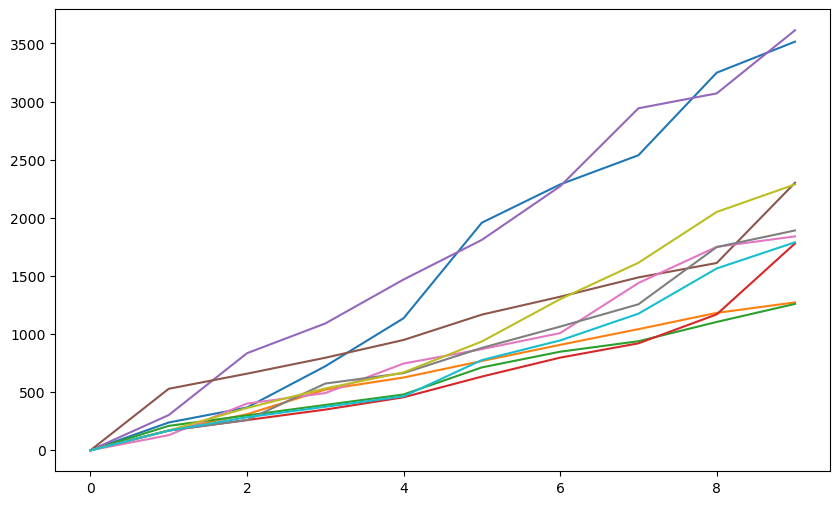

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

df_first_10 = df_20_series.iloc[:10, :10]

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(df_first_10)):
    ax.plot(df_first_10.columns, df_first_10.iloc[i], label=f'Row {i}')
plt.show()

### Normalizing Data

In [ ]:
# data = df_subset.gold_t

# from pandas import Series
# from sklearn.preprocessing import MinMaxScaler

# # define contrived series
# series = data.apply(pd.Series)
# print(series)

# # prepare data for normalization
# values = series.values


# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(values)
# print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

# #values = values.reshape((len(values), 1))
